In [ ]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/MyDrive/BT5151 Grp Proj!'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/BT5151 Grp Proj!
/content/gdrive/.shortcut-targets-by-id/1labx7YQZuN5vcXgIX4tcowPIRSJ2C_Db/BT5151 Grp Proj!


In [ ]:
import torch
print("Is CUDA available: ", torch.cuda.is_available())
print("Num GPUs Available: ", torch.cuda.device_count())

Is CUDA available:  True
Num GPUs Available:  1


In [ ]:
import torch
from torch import nn
from torch.optim import AdamW
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import Accuracy
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd

# Hybrid

In [ ]:
class HybridCNNTransformer(pl.LightningModule):
    def __init__(self, num_classes=20, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.cnn = models.resnet18(pretrained=True)  # Using ResNet18 as the CNN
        self.cnn.fc = nn.Identity()  # Remove the final FC layer
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=512, nhead=8), num_layers=1)
        self.classifier = nn.Linear(512, num_classes)
        self.criterion = nn.CrossEntropyLoss()

        for param in self.cnn.parameters():
          param.requires_grad = False  # Freeze all parameters in the ResNet
        for param in self.transformer.parameters():
          param.requires_grad = False  # Freeze all parameters in the ResNet

    def forward(self, x):
        cnn_features = self.cnn(x).unsqueeze(1)  # Add sequence dimension
        transformer_output = self.transformer(cnn_features).squeeze(1)
        logits = self.classifier(transformer_output)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(logits, y))

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.learning_rate)

### CNN architecture

# Defining data loaders

In [ ]:
import os

In [ ]:
class TopKFilesDataset(torch.utils.data.Dataset):
  """
  Custom dataset class to load top K files from each folder.
  """

  def __init__(self, root_dir, k, transform=None):
    """
    Args:
      root_dir: Path to the directory containing subfolders.
      k: Number of top files to load from each subfolder.
      transform: Optional transformation to apply to loaded data (e.g., image pre-processing).
    """
    self.root_dir = root_dir
    self.k = k
    self.transform = transform

    # Initialize empty lists to store file paths and labels
    self.data = []
    self.labels = []
    self.ids = []  # Add a new list to store unique IDs
    self.process_folders()

  def process_folders(self):
      """
      Iterates through subfolders, collects top K file paths, assigns IDs, and stores them.
      """
      unique_id = 0  # Track unique ID for each image
      for folder in os.listdir(self.root_dir):
        folder_path = os.path.join(self.root_dir, folder)
        if os.path.isdir(folder_path):
          # Extract label from folder name (modify logic if labels are stored elsewhere)
          label = folder

          files = os.listdir(folder_path)
          # Sort files (optional: modify for specific order)
          sorted_files = sorted(files)
          for file in sorted_files[:self.k]:
            file_path = os.path.join(folder_path, file)
            self.data.append(file_path)
            self.labels.append(label)
            self.ids.append(unique_id)  # Assign and append unique ID
            unique_id += 1  # Increment ID for the next image

  def __len__(self):
    """
    Returns the total number of files loaded from all folders.
    """
    return len(self.data)

  def __getitem__(self, idx):
      """
      Loads a specific data point (file) with its ID and label based on the index.

      Args:
          idx: Index of the data point to load.

      Returns:
          A tuple containing the loaded image (float), its ID (float), and its label (float).
      """
      image = self.data[idx]
      # image = self.transform(image)  # Apply transformation if needed
      label = self.labels[idx]
      image_id = self.ids[idx]

      return image.float(), label.float()

In [ ]:
# 10% subsampling yield 1261+271+271=1.8K
# hence assuming equal class dist, each class we then get 1.8K/20 = 90 samples

In [ ]:
main_directory = 'foods'
k = 90  # Number of top files per folder, based on smallest food category, treating all food categories

# Create the dataset
dataset = TopKFilesDataset(main_directory, k)

In [ ]:
# Access data and labels directly from the dataset object (no need to iterate)
all_data = dataset.data
all_labels = dataset.labels
all_ids = dataset.ids

In [ ]:
show_size = 5
all_data[:show_size]

['foods/char_kway_teow/00HJMXRDBKB1WHESETYSO3UV.jpg',
 'foods/char_kway_teow/00XR2QGM9FMKDD0V7FENF7YP.jpg',
 'foods/char_kway_teow/01X6VR0FM7TNPX0U5LLRO6J9.jpg',
 'foods/char_kway_teow/02CYB4IKO7OEO1F0YR0VLPWF.jpg',
 'foods/char_kway_teow/02NQQZSC5XUAMU08GSF7ET3F.jpg']

In [ ]:
all_labels[:show_size]

['char_kway_teow',
 'char_kway_teow',
 'char_kway_teow',
 'char_kway_teow',
 'char_kway_teow']

In [ ]:
all_ids[:show_size]

[0, 1, 2, 3, 4]

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Create a LabelEncoder object
le = LabelEncoder()
encoded_labels = le.fit_transform(all_labels)
encoded_labels

array([ 2,  2,  2, ..., 13, 13, 13])

In [ ]:
# Get the mapping of labels to encoded integers
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Print the label encoder mapping
print(label_mapping)

{'ban_mian': 0, 'chai_tow_kway': 1, 'char_kway_teow': 2, 'char_siew_rice': 3, 'chicken_masala': 4, 'chicken_rice': 5, 'curry_puff': 6, 'goreng_pisang': 7, 'hokkien_prawn_mee': 8, 'kway_chap': 9, 'laksa': 10, 'lotong_w_sayur_lodeh': 11, 'mee_rebus': 12, 'nasi_lemak': 13, 'rojak': 14, 'roti_john': 15, 'roti_prata': 16, 'satay': 17, 'siew_mai': 18, 'spring_roll': 19}


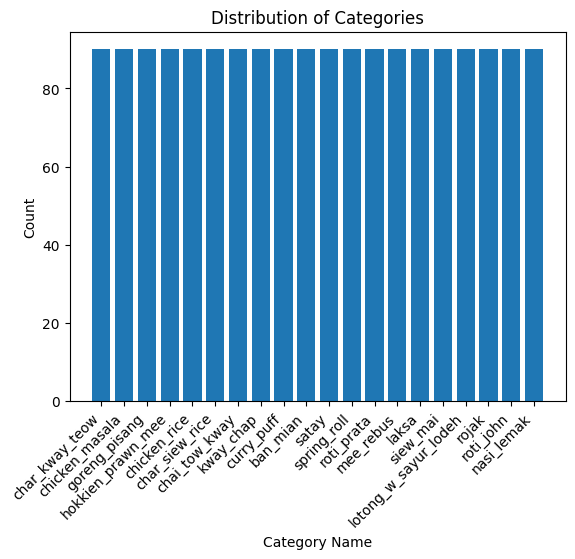

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Get the distribution of labels (counts)
label_counts = Counter(all_labels)

# Extract category names and counts
category_names = list(label_counts.keys())
counts = list(label_counts.values())

# Create the bar chart
plt.bar(category_names, counts)  # Or plt.barh(category_names, counts) for horizontal bars

# Set labels and title
plt.xlabel("Category Name")
plt.ylabel("Count")
plt.title("Distribution of Categories")

# Optional: Rotate category names if too many (for better readability)
if len(category_names) > 10:
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified split for train, validation, and test sets (using IDs and labels)
train_ids, test_val_ids, train_labels, test_val_labels = train_test_split(
      all_ids, encoded_labels, test_size=0.2, stratify=all_labels, random_state=42
  )

# Further split test-validation set (using IDs and labels from previous split)
test_ids, val_ids, test_labels, val_labels = train_test_split(
      test_val_ids, test_val_labels, test_size=0.5, stratify=test_val_labels, random_state=42
  )

In [ ]:
# Print or use the train, validation, and test IDs and labels
print("Train IDs:", train_ids)
print("Train Labels:", train_labels)

print("Validation IDs:", val_ids)
print("Validation Labels:", val_labels)

print("Test IDs:", test_ids)
print("Test Labels:", test_labels)

Train IDs: [1172, 152, 294, 1178, 18, 865, 140, 1523, 558, 8, 651, 513, 1262, 906, 1264, 838, 1657, 22, 1401, 1703, 310, 1624, 317, 1199, 1581, 638, 157, 724, 141, 1036, 1141, 776, 1666, 1245, 92, 93, 1644, 1316, 468, 1248, 938, 188, 928, 779, 554, 334, 774, 855, 1385, 635, 1072, 560, 169, 1696, 1750, 1570, 180, 222, 506, 454, 208, 509, 479, 710, 269, 676, 1056, 1167, 1754, 1249, 607, 483, 980, 1170, 1669, 1059, 171, 876, 295, 1114, 360, 1113, 1590, 512, 836, 1693, 1005, 1425, 1374, 366, 1195, 423, 126, 748, 716, 1691, 325, 1792, 20, 219, 376, 147, 27, 1071, 218, 1740, 1575, 1155, 256, 1636, 1566, 954, 368, 1420, 259, 1259, 1662, 25, 528, 247, 751, 1793, 874, 1492, 110, 326, 1154, 863, 1460, 332, 576, 995, 1180, 445, 813, 1107, 699, 402, 891, 675, 1185, 1088, 871, 538, 1208, 1635, 659, 915, 1777, 1320, 432, 1665, 1526, 766, 1064, 816, 481, 122, 897, 1302, 825, 1065, 15, 745, 1399, 26, 1396, 472, 1367, 596, 232, 170, 1746, 167, 842, 1622, 642, 1708, 9, 534, 49, 1152, 1210, 1429, 1393, 1

In [ ]:
import cv2

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
  """
  Custom dataset class for loading data and labels based on provided IDs.
  """
  def __init__(self, dataset, index):
      self.dataset = dataset
      print(self.dataset.data)
      self.data = list([self.dataset.data[idx] for idx in index])
      self.labels = list([encoded_labels[idx] for idx in index])
      self.images = []

      # Define transformations
      self.transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize((224, 224)),  # Resize images to a standard size
          # transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
          # transforms.RandomRotation(10),  # Random rotation
          # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter for augmentation
          # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformations
          transforms.ToTensor(),  # Convert images to tensor
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
      ])

      for img_path in self.data:
        # given code modified for convenience
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.images.append(image)

  def __len__(self):
        return len(self.data)

  def __getitem__(self, index):
      image = self.images[index]
      image = self.transform(image)
      label = float(self.labels[index])

      return image.float(), torch.tensor(label).type(torch.LongTensor)

In [ ]:
# K=100
train_dataset = ImageDataset(dataset, train_ids)
valid_dataset = ImageDataset(dataset, val_ids)
test_dataset = ImageDataset(dataset, test_ids)

['foods/char_kway_teow/00HJMXRDBKB1WHESETYSO3UV.jpg', 'foods/char_kway_teow/00XR2QGM9FMKDD0V7FENF7YP.jpg', 'foods/char_kway_teow/01X6VR0FM7TNPX0U5LLRO6J9.jpg', 'foods/char_kway_teow/02CYB4IKO7OEO1F0YR0VLPWF.jpg', 'foods/char_kway_teow/02NQQZSC5XUAMU08GSF7ET3F.jpg', 'foods/char_kway_teow/03HAR18GVOTIAJETRAODLTJH.jpg', 'foods/char_kway_teow/055834HNYIJD73GZFY5VJT2K.jpg', 'foods/char_kway_teow/06C91W1A9FEVC47VP4V03SD1.jpg', 'foods/char_kway_teow/06TZO5PE31O0S2EDZQH0UKM8.jpg', 'foods/char_kway_teow/07DRDPA6W6MC5HGVFIFA568L.jpg', 'foods/char_kway_teow/07SLNSR86EEXY2M0ESIA9PKS.jpg', 'foods/char_kway_teow/0956DPRIUK2L4TRSYOCMUB48.jpg', 'foods/char_kway_teow/095XTD486MUW5AYKDT4ZHZLD.jpg', 'foods/char_kway_teow/09L1RMOCJ1E2F7OGF8NZWZ1Y.jpg', 'foods/char_kway_teow/0BPE76Y5MTTLS4H75TOQZJED.jpg', 'foods/char_kway_teow/0BPWUGEAZEHLDY3K600IU98B.jpg', 'foods/char_kway_teow/0D3XPCODENMCPPJIOFB0VWV2.jpg', 'foods/char_kway_teow/0DO7267FQOLUWH9N1YWW3IPA.jpg', 'foods/char_kway_teow/0E82UWIX8TM43UXNIRNYI1Z

In [ ]:
# Create separate Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
next(iter(train_loader))

[tensor([[[[ 1.2728,  1.2728,  1.2385,  ...,  1.0502,  1.0673,  1.0673],
           [ 1.2043,  1.2043,  1.2214,  ...,  1.0502,  1.0673,  1.0844],
           [ 1.2214,  1.2043,  1.2043,  ...,  1.0502,  1.0502,  1.0502],
           ...,
           [ 0.9817,  0.9988,  1.0159,  ...,  0.7933,  0.7933,  0.7933],
           [ 0.9817,  1.0159,  1.0159,  ...,  0.7762,  0.7762,  0.7762],
           [ 1.0159,  1.0502,  1.0502,  ...,  0.7591,  0.7762,  0.7591]],
 
          [[-1.0728, -1.0728, -1.1078,  ..., -1.3529, -1.3704, -1.3880],
           [-1.1429, -1.1253, -1.1253,  ..., -1.3529, -1.3529, -1.3529],
           [-1.1078, -1.1253, -1.1253,  ..., -1.3529, -1.3704, -1.3704],
           ...,
           [-1.4055, -1.3880, -1.3704,  ..., -1.4055, -1.4230, -1.4405],
           [-1.4055, -1.3529, -1.3529,  ..., -1.4230, -1.4055, -1.4230],
           [-1.3704, -1.3179, -1.3179,  ..., -1.4405, -1.4055, -1.4230]],
 
          [[-0.9156, -0.9156, -0.9504,  ..., -1.2119, -1.2119, -1.2293],
           [-

In [ ]:
# Check DataLoader lengths and shapes of data
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

# Grab a single batch from each DataLoader
train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))
test_images, test_labels = next(iter(test_loader))

# Check the shape of the images and labels
print("Shape of train images:", train_images.shape)  # Expect [batch_size, 3, 224, 224]
print("Shape of train labels:", train_labels.shape)  # Expect [batch_size]

print("Shape of validation images:", val_images.shape)
print("Shape of validation labels:", val_labels.shape)

print("Shape of test images:", test_images.shape)
print("Shape of test labels:", test_labels.shape)

Number of training batches: 45
Number of validation batches: 6
Number of test batches: 6
Shape of train images: torch.Size([32, 3, 224, 224])
Shape of train labels: torch.Size([32])
Shape of validation images: torch.Size([32, 3, 224, 224])
Shape of validation labels: torch.Size([32])
Shape of test images: torch.Size([32, 3, 224, 224])
Shape of test labels: torch.Size([32])


## Visualizing sample

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

In [ ]:
def invert_dict(my_dict):
  """
  Inverts a dictionary, creating a new dictionary where possible.

  Args:
      my_dict: The dictionary to invert.

  Returns:
      A new dictionary with values as keys and keys as values (if possible),
      or None if a key appears multiple times.
  """
  inverted_dict = {}
  for key, value in my_dict.items():
    if value in inverted_dict:
      # If the value already exists as a key, inversion isn't possible (multiple keys map to the same value)
      return None
    inverted_dict[value] = key
  return inverted_dict


inverted_mapping = invert_dict(label_mapping.copy())
# inverted_mapping = invert_dict(mapping.copy())
print(inverted_mapping)

{0: 'ban_mian', 1: 'chai_tow_kway', 2: 'char_kway_teow', 3: 'char_siew_rice', 4: 'chicken_masala', 5: 'chicken_rice', 6: 'curry_puff', 7: 'goreng_pisang', 8: 'hokkien_prawn_mee', 9: 'kway_chap', 10: 'laksa', 11: 'lotong_w_sayur_lodeh', 12: 'mee_rebus', 13: 'nasi_lemak', 14: 'rojak', 15: 'roti_john', 16: 'roti_prata', 17: 'satay', 18: 'siew_mai', 19: 'spring_roll'}


In [ ]:
inverted_mapping[1] = "fried_carrot_cake"
inverted_mapping[11] = "lontong_with_sayur_lodeh"
inverted_mapping

{0: 'ban_mian',
 1: 'fried_carrot_cake',
 2: 'char_kway_teow',
 3: 'char_siew_rice',
 4: 'chicken_masala',
 5: 'chicken_rice',
 6: 'curry_puff',
 7: 'goreng_pisang',
 8: 'hokkien_prawn_mee',
 9: 'kway_chap',
 10: 'laksa',
 11: 'lontong_with_sayur_lodeh',
 12: 'mee_rebus',
 13: 'nasi_lemak',
 14: 'rojak',
 15: 'roti_john',
 16: 'roti_prata',
 17: 'satay',
 18: 'siew_mai',
 19: 'spring_roll'}

In [ ]:
# # Create a pandas DataFrame
food_dict_df = pd.DataFrame.from_dict(inverted_mapping, orient='index', columns=['food'])
food_dict_df

,food
0,ban_mian
1,fried_carrot_cake
2,char_kway_teow
3,char_siew_rice
4,chicken_masala
5,chicken_rice
6,curry_puff
7,goreng_pisang
8,hokkien_prawn_mee
9,kway_chap


In [ ]:
food_nutrition = pd.read_csv('/content/gdrive/MyDrive/BT5151 Grp Proj!/food_nutrition.csv')
food_nutrition.head()

,food,serving_size_g,calories_kcal,protein_g,carbs_g,fat_g,saturated_fat_g,dietary_fibre_g,cholesterol_mg,sodium_mg
0,curry_puff,37,131,4,11,8,3.8,0.6,0,168
1,char_siew_rice,327,605,24,91,16,11.9,5.9,56,880
2,kway_chap,611,650,33,70,26,11.6,4.3,348,2303
3,ban mian,528,475,22,48,22,8.4,3.2,232,2196
4,chicken rice,382,607,25,75,23,8.7,2.0,47,1287


In [ ]:
# Refactor column to replace spaces with underscores
food_nutrition['food'] = food_nutrition['food'].str.replace(' ', '_')
food_nutrition

,food,serving_size_g,calories_kcal,protein_g,carbs_g,fat_g,saturated_fat_g,dietary_fibre_g,cholesterol_mg,sodium_mg
0,curry_puff,37,131,4,11,8,3.8,0.6,0,168
1,char_siew_rice,327,605,24,91,16,11.9,5.9,56,880
2,kway_chap,611,650,33,70,26,11.6,4.3,348,2303
3,ban_mian,528,475,22,48,22,8.4,3.2,232,2196
4,chicken_rice,382,607,25,75,23,8.7,2.0,47,1287
5,siew_mai,16,29,1,3,1,0.4,0.3,4,99
6,fried_carrot_cake,295,493,2,42,35,14.1,5.9,109,1289
7,chicken_masala,455,860,87,16,50,18.7,0.0,255,2330
8,char_kway_teow,384,744,23,76,38,29.2,7.3,234,1459
9,goreng_pisang,65,197,1,36,5,3.4,2.3,0,103


In [ ]:
# Left join on 'food' column
joined_df = pd.merge(food_dict_df, food_nutrition, on='food', how='left')
joined_df

,food,serving_size_g,calories_kcal,protein_g,carbs_g,fat_g,saturated_fat_g,dietary_fibre_g,cholesterol_mg,sodium_mg
0,ban_mian,528,475,22,48,22,8.4,3.2,232,2196
1,fried_carrot_cake,295,493,2,42,35,14.1,5.9,109,1289
2,char_kway_teow,384,744,23,76,38,29.2,7.3,234,1459
3,char_siew_rice,327,605,24,91,16,11.9,5.9,56,880
4,chicken_masala,455,860,87,16,50,18.7,0.0,255,2330
5,chicken_rice,382,607,25,75,23,8.7,2.0,47,1287
6,curry_puff,37,131,4,11,8,3.8,0.6,0,168
7,goreng_pisang,65,197,1,36,5,3.4,2.3,0,103
8,hokkien_prawn_mee,442,522,18,69,19,7.3,4.4,133,1423
9,kway_chap,611,650,33,70,26,11.6,4.3,348,2303


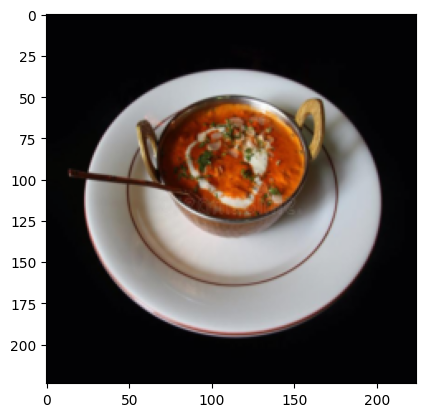

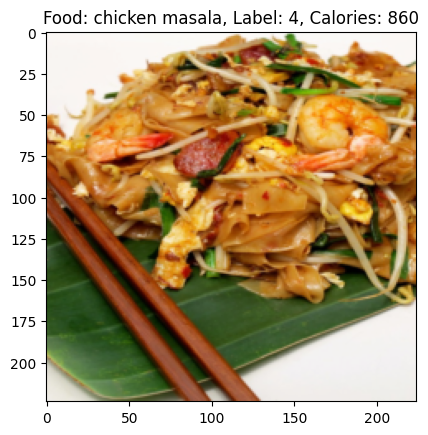

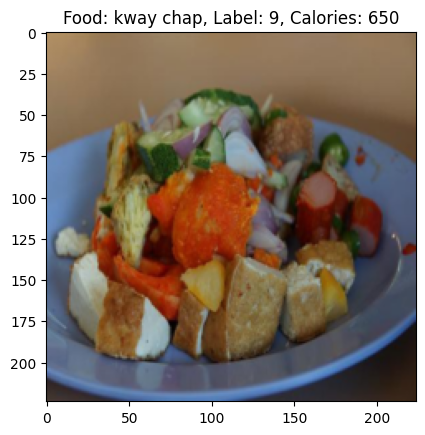

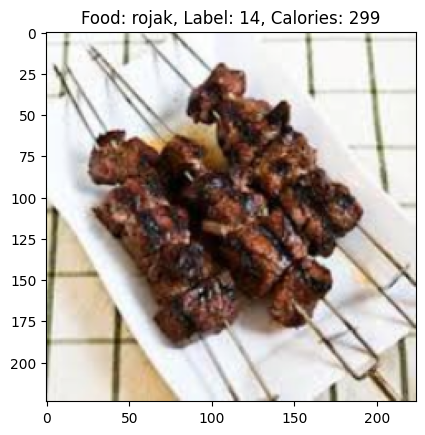

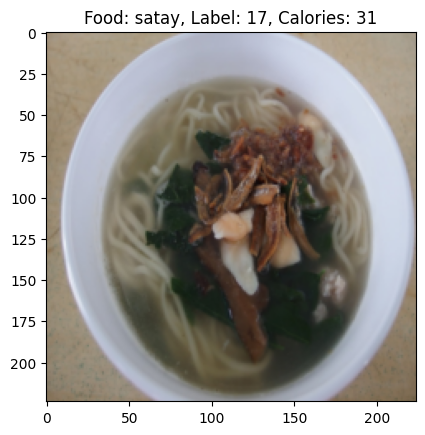

In [ ]:
size = 5

# Plot the images in the batch, along with the corresponding labels
for idx in range(size):
    imshow(images[idx])
    label_idx = labels[idx].item()
    if label_idx:
      food_name = str(inverted_mapping[label_idx]).replace('_', ' ')
      plt.title(f"Food: {food_name}, Label: {int(label_idx)}, Calories: {joined_df.loc[label_idx, 'calories_kcal']}")

### Validating all food labels

In [ ]:
# # Check the class to index mapping
# print(full_dataset.class_to_idx)

# # Get all labels from the dataset
# all_labels = [label for _, label in full_dataset]

# # Count each label
# from collections import Counter
# label_counts = Counter(all_labels)
# print(label_counts)

# Model train n test

In [ ]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",  # Directory where the checkpoints will be saved
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,  # Save only the best checkpoint
    verbose=True,
    monitor="val_acc",  # Metric to monitor (validation accuracy)
    mode="max",  # Maximize the monitored metric (val_acc)
    # monitor="val_loss",  # Metric to monitor
    # mode="min",  # Minimize the monitored metric (val_loss)
    save_last=True  # Additionally, save the last model state at the end of training
)

In [ ]:
# Model training with the checkpoint callback
model = HybridCNNTransformer()
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=5,
    log_every_n_steps=30,
    callbacks=[checkpoint_callback]  # Include the checkpoint callback in training
)
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.0MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.bat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 45: 'val_acc' reached 0.41861 (best 0.41861), saving model to '/content/gdrive/.shortcut-targets-by-id/1labx7YQZuN5vcXgIX4tcowPIRSJ2C_Db/BT5151 Grp Proj!/checkpoints/best-checkpoint-epoch=00-val_loss=1.96.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 90: 'val_acc' reached 0.55579 (best 0.55579), saving model to '/content/gdrive/.shortcut-targets-by-id/1labx7YQZuN5vcXgIX4tcowPIRSJ2C_Db/BT5151 Grp Proj!/checkpoints/best-checkpoint-epoch=01-val_loss=1.53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 135: 'val_acc' reached 0.59968 (best 0.59968), saving model to '/content/gdrive/.shortcut-targets-by-id/1labx7YQZuN5vcXgIX4tcowPIRSJ2C_Db/BT5151 Grp Proj!/checkpoints/best-checkpoint-epoch=02-val_loss=1.34.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 180: 'val_acc' reached 0.60979 (best 0.60979), saving model to '/content/gdrive/.shortcut-targets-by-id/1labx7YQZuN5vcXgIX4tcowPIRSJ2C_Db/BT5151 Grp Proj!/checkpoints/best-checkpoint-epoch=03-val_loss=1.24.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 225: 'val_acc' reached 0.63284 (best 0.63284), saving model to '/content/gdrive/.shortcut-targets-by-id/1labx7YQZuN5vcXgIX4tcowPIRSJ2C_Db/BT5151 Grp Proj!/checkpoints/best-checkpoint-epoch=04-val_loss=1.20.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5686679482460022     │
│         test_loss         │    1.1778706312179565     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1778706312179565, 'test_acc': 0.5686679482460022}]